---
date: "2025-1-7T14:57:00.00Z"
description: "Trying out PydanticAI"
published: true
tags:
  - python
  - llm
  - anthropic
  - bedrock
time_to_read: 5
title: "PydanticAI + Amazon Bedrock"
type: post
---

Recently, there has been alot of noise about LLM agents. I've observed customers are frequently stuck in the undifferentiated stages of starting AI projects when choosing between competing tools and frameworks. This is backed by a recent blog from Anthropic [Building Effective Agents](https://www.anthropic.com/research/building-effective-agents) recommending to work at lower levels of abstraction.

Recently I've been enjoying building with the brand new PydanticAI library which has just yesterday released support for Amazon Bedrock in release `0.0.36`. My first impressions are that this is at just the right level of abstraction for building LLM powered systems. In this post, I'll implement each of the Anthropic agent patterns with PydanticAI. Note this is very early days for this framework so be wary of breaking changes.

Please remember the caveat that a large class of problems can be solved with simpler algorithms. You should consider those first since they may well be more reliable, cheaper and more interpretable.

0) [Hello World](#hello-world)
1) [Pydantic Model Structured Output](#pydantic-model-structured-output)
2) [Building block: The Augmented LLM](#the-augmented-llm-with-structured-output)
4) [Workflow: Prompt chaining](#workflow-prompt-chaining)
5) [Workflow: Routing](#workflow-routing)
6) [Workflow: Parallelization](#workflow-parallelization)
7) [Workflow: Evaluator-optimizer](#workflow-evaluator-optimizer)
8) [Workflow: Orchestrator-workers](#workflow-orchestrator-workers)

# Hello World
Let's get started by installing `pydantic-ai` with bedrock support

In [3]:
%uv add 'pydantic-ai-slim[bedrock]' pydantic-graph boto3

Resolved 187 packages in 136ms                                       
Audited 184 packages in 0.57ms                                       
Note: you may need to restart the kernel to use updated packages.


Now, assuming we have AWS credentials configured, we can make an LLM call to Amazon Bedrock. We'll use the `bedrock:us.amazon.nova-lite-v1:0` model for this blog. Amazon Nova Lite is a very low cost mid-sized multimodal model that is lightning fast for processing image, video, and text inputs.

In [20]:
from pydantic_ai import Agent

agent = Agent(
    model='bedrock:us.amazon.nova-lite-v1:0',
    system_prompt='Be concise, reply with one sentence.'
)

result = agent.run_sync('Where does "hello world" come from?')  
print(result.data)

17:57:32.519 agent run
17:57:32.520   preparing model request params
17:57:32.521   chat us.amazon.nova-lite-v1:0
"Hello, world!" originates from the first example program in the 1978 book "The C Programming Language" by Brian Kernighan and Dennis Ritchie.


## A note on Observability

While we could scroll through the verbose logs to see every detail of the LLM interaction, it get's pretty unwieldy for longer interactions, especially when there are loops in the workflows. There will also be traces of interactions when we span multiple code paths from a single interaction. Furthermore, there will be application metrics we'll want to track over time. This is there observability comes in. There is a lot to learn from traditional software engineering here. If you want to see what good looks like then check out [Pydantic logfire](https://logfire.pydantic.dev/docs/).

In [ ]:
%uv add logfire

!logfire auth
!logfire projects use stephenhib-blog

import logfire
from pydantic_ai import Agent

logfire.configure(send_to_logfire='if-token-present')
Agent.instrument_all()

Resolved 187 packages in 4ms
Audited 184 packages in 0.31ms
Note: you may need to restart the kernel to use updated packages.
You are already logged in. (Your credentials are stored in 
/Users/stephenhibbert/.logfire/default.toml)
Project configured successfully. You will be able to view it at: 
https://logfire.pydantic.dev/stephenhibbert/stephenhib-blog


Logfire project URL: ]8;id=852728;https://logfire.pydantic.dev/stephenhibbert/stephenhib-blog\https://logfire.pydantic.dev/stephenhibbert/stephenhib-blog]8;;\


![Logfire UI](../public/images/pydantic-ai/logfire.png)

## Pydantic Model Structured Output

Let's start with a simple structured output, one of the neat building blocks of PydanticAI. Read my [previous post](https://stephenhib.com/posts/llm-structured-output) if you're interested in the theory of how this works.

In [21]:
from pydantic_ai.models import ModelSettings
from pydantic_ai import Agent
from pydantic import BaseModel

import nest_asyncio
nest_asyncio.apply()  # This allows for nested event loops in Jupyter Notebooks

class Character(BaseModel):
    name: str
    animal: str
    age: int

agent = Agent(
    model='bedrock:us.amazon.nova-lite-v1:0',
    result_type=Character,
    system_prompt="You're a fun, helpful assistant"
)

result = agent.run_sync('Create a fictional animal character')
my_animal = result.data
print(my_animal, type(my_animal)) # This is a Pydantic data model
print(my_animal.age, type(my_animal.age)) # And I can access model fields without parsing strings 😁
result.new_messages() # print the conversation history.

17:58:04.724 agent run
17:58:04.724   preparing model request params
17:58:04.724   chat us.amazon.nova-lite-v1:0
name='Luna' animal='Tiger' age=5 <class '__main__.Character'>
5 <class 'int'>


[ModelRequest(parts=[SystemPromptPart(content="You're a fun, helpful assistant", dynamic_ref=None, part_kind='system-prompt'), UserPromptPart(content='Create a fictional animal character', timestamp=datetime.datetime(2025, 3, 7, 17, 58, 4, 724734, tzinfo=datetime.timezone.utc), part_kind='user-prompt')], kind='request'),
 ModelResponse(parts=[TextPart(content="<thinking>I need to create a fictional animal character with a name, an animal type, and an age. I will use the 'final_result' tool to generate this character.</thinking>\n", part_kind='text'), ToolCallPart(tool_name='final_result', args={'name': 'Luna', 'animal': 'Tiger', 'age': 5}, tool_call_id='tooluse_nJ6fpLH-TaKdkUfTnSA8Yw', part_kind='tool-call')], model_name='us.amazon.nova-lite-v1:0', timestamp=datetime.datetime(2025, 3, 7, 17, 58, 5, 916352, tzinfo=datetime.timezone.utc), kind='response'),
 ModelRequest(parts=[ToolReturnPart(tool_name='final_result', content='Final result processed.', tool_call_id='tooluse_nJ6fpLH-TaKdkU

Note that PydanticAI abstracts every LLM call through it's [Agent](https://ai.pydantic.dev/agents/) class. This is different from Anthropic's definition of Agents but we won't be pedantic 🙄. I consider the Pydantic Agent class as a building block to create systems with agency but everyone seems to have their own definition. The takeaway for this first section is that we have a way to call an LLM in a convenient output format.

## The Augmented LLM with Structured Output
There are some situations where we want models to have access to external tools in order to generate a response. Tools **augment** the language model by providing external context. Common augmentations include:
- Retrieval (RAG): query/results on an index of documents
- Memory: read/write on a database of previous interactions
- APIs: request/response on an API

> ![The Augmented LLM](../public/images/pydantic-ai/aug-llm.webp)
> Anthropic - Building effective agents

However, since the tool is just a Python function, we can augment with anything we can implement in code! Let's see an example of an augmented LLM that has access to call code functions. In PydanticAI we can do this with the `@agent.tool_plain` decorator.


In [23]:
import random
import nest_asyncio
nest_asyncio.apply()  # This allows for nested event loops in Jupyter Notebooks

from pydantic_ai import Agent, RunContext

agent = Agent(
    model='bedrock:us.amazon.nova-lite-v1:0',
    deps_type=str,
    system_prompt=(
        "You're a dice game, you should roll the die and see if the number "
        "you get back matches the user's guess. If so, tell them they're a winner."
    ),
)


@agent.tool_plain
def roll_die() -> str:
    """Roll a six-sided die and return the result."""
    return str(random.randint(1, 6))


dice_result = agent.run_sync('My guess is 4')
print(dice_result.data)
dice_result.new_messages()

18:04:48.256 agent run
18:04:48.256   preparing model request params
18:04:48.257   chat us.amazon.nova-lite-v1:0
18:04:49.330   running tools: roll_die
18:04:49.331   preparing model request params
18:04:49.332   chat us.amazon.nova-lite-v1:0
<thinking>I have rolled the die and got a 2. The user's guess was 4, so I need to inform the user that they did not win.</thinking>



Here is the result of the die roll: 2. Since your guess was 4, you are not a winner this time. Try again!


[ModelRequest(parts=[SystemPromptPart(content="You're a dice game, you should roll the die and see if the number you get back matches the user's guess. If so, tell them they're a winner.", dynamic_ref=None, part_kind='system-prompt'), UserPromptPart(content='My guess is 4', timestamp=datetime.datetime(2025, 3, 7, 18, 4, 48, 256934, tzinfo=datetime.timezone.utc), part_kind='user-prompt')], kind='request'),
 ModelResponse(parts=[TextPart(content="<thinking>The user has made a guess, and I need to roll a die to see if it matches the user's guess. I will use the tool 'roll_die' to simulate the roll of a six-sided die.</thinking>\n", part_kind='text'), ToolCallPart(tool_name='roll_die', args={}, tool_call_id='tooluse_6TiqYDSiQhizqDjW_jnN2A', part_kind='tool-call')], model_name='us.amazon.nova-lite-v1:0', timestamp=datetime.datetime(2025, 3, 7, 18, 4, 49, 329330, tzinfo=datetime.timezone.utc), kind='response'),
 ModelRequest(parts=[ToolReturnPart(tool_name='roll_die', content='2', tool_call_

You can see we made two LLM calls in the message logs. The first LLM request took the user query and predicted that it should use the `roll_die` tool. The second LLM generates the final response back to the user. Note if we ask a question about something off-topic that dosen't include a guess then we only have a single LLM call since the model does not decide to call the `roll_die()` function.

In [24]:
result = agent.run_sync('How are you today?')
print(result.data)

18:05:09.377 agent run
18:05:09.377   preparing model request params
18:05:09.378   chat us.amazon.nova-lite-v1:0
<thinking> The User is asking about my current state. I do not have feelings or states but I can respond in a friendly manner to the User's question. </thinking>
I'm just a program, so I don't have feelings, but I'm here and ready to help you with anything you need. How can I assist you today?


Now we've implemented the Augmented LLM, we have a pretty general building block to apply to our workflows! In the above example we return a string, but it's really easy to specify other datastructures too by changing `result_type` to return our model.

In [25]:
class Result(BaseModel):
    roll_guess: int
    roll_result: int
    message: str

agent = Agent(
    model='bedrock:us.amazon.nova-lite-v1:0',
    result_type=Result,
    model_settings=ModelSettings(
        temperature=1 # set the temperature to 1 to stop rolling 4 all the time!
    ),
    system_prompt=(
        "You're a dice game, you should roll the die and see if the number "
        "you get back matches the user's guess. If so, tell them they're a winner."
    ),
)

dice_result = agent.run_sync('My guess is 6')
print(dice_result.data)

18:05:27.560 agent run
18:05:27.561   preparing model request params
18:05:27.561   chat us.amazon.nova-lite-v1:0
roll_guess=6 roll_result=3 message='Your guess was 6, but I rolled a 3. Better luck next time!'


# Workflow: Prompt chaining
Let's apply our Augmented LLM building block to make a predefined workflow of chaining prompts together. Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. This can be applied in a situation when a task can be decomposed into fixed subtasks. It's also great for applying guardrails at known points in the workflow.

> ![Prompt chaining](../public/images/pydantic-ai/chain.png)
> Anthropic - Building effective agents

Let's make a prompt chain with PydanticAI to build a joke generator.

In [30]:
from pydantic_ai import Agent
from pydantic import BaseModel, Field
from typing import Literal

import nest_asyncio
nest_asyncio.apply()  # This allows for nested event loops in Jupyter Notebooks

class Joke(BaseModel):
    setup: str
    punchline: str

class NsfwGuardrail(BaseModel):
    label: Literal["HARMLESS", "NSFW"] = Field(
        description="The predicted class label, output either HARMLESS or NSFW (Not Safe For Work).",
    )

class Explainer(BaseModel):
    reasoning: str = Field(
        description="The explanation why this joke is funny."
    )

joke_agent = Agent(
    model='bedrock:anthropic.claude-3-sonnet-20240229-v1:0',
    deps_type=str,
    model_settings=ModelSettings(
        temperature=1 # set the temperature to 1 to be more creative, and possibly more funny
    ),
    system_prompt=(
        "You're a funny joke writer."
    ),
    result_type=Joke
)

guardrail_agent = Agent(
    model='bedrock:anthropic.claude-3-sonnet-20240229-v1:0',
    deps_type=str,
    system_prompt=(
        "You're a moderator ensuring content is safe for work."
    ),
    result_type=NsfwGuardrail
)

joke_explainer_agent = Agent(
    model='bedrock:anthropic.claude-3-sonnet-20240229-v1:0',
    deps_type=str,
    system_prompt=(
        "All you do is explain jokes."
    ),
    result_type=Explainer
)

result1 = joke_agent.run_sync('Write a joke about cheese.')
# Note how we pass the conversation history between PydanticAI agents with the `all_messages()` function
result2 = guardrail_agent.run_sync('Judge whether or not this joke is inappropriate.', message_history=result1.all_messages())

if result2.data.label == "HARMLESS":
    # We again pass the message history of the second LLM call, but this will not have 
    result3 = joke_explainer_agent.run_sync('Why is this Joke funny?', message_history=result1.all_messages())
else:
    result3 = joke_explainer_agent.run_sync('Why is this Joke inappropriate?', message_history=result1.all_messages())
    print("Stopped early due to inappropriate joke")

print(
    f'The joke "{result1.data.setup}" '
    f'with the punchline "{result1.data.punchline}" '
    f'is {result2.data.label} ',
    f'because {result3.data.reasoning}',
)

18:15:11.352 joke_agent run
18:15:11.354   preparing model request params
18:15:11.354   chat anthropic.claude-3-sonnet-20240229-v1:0
18:15:13.179 guardrail_agent run
18:15:13.180   preparing model request params
18:15:13.180   chat anthropic.claude-3-sonnet-20240229-v1:0
18:15:14.310 joke_explainer_agent run
18:15:14.310   preparing model request params
18:15:14.311   chat anthropic.claude-3-sonnet-20240229-v1:0
The joke "What kind of cheese can never be yours?" with the punchline "Nacho cheese!" is HARMLESS  because This joke is funny because it plays on the phrase "not your cheese" which sounds similar to "nacho cheese", a type of melted cheese dip popular with tortilla chips. The unexpected pun and cheesy wordplay creates an element of surprise and humor.


# Workflow: Routing

Routing is all about classifying an input and directing it to a specialised followup task. This allows separation of concerns to independently optimise different downstream processes. Routing works well when the input distribution can be well seperated into distinct classes.

> ![The LLM Router](../public/images/pydantic-ai/router.webp)
> Anthropic

Let's make a simple model router that directs customer service questions to different specialised agents base on the class of the query. We'll assume the users will either be asking about terms & conditions, refunds or general Q/A.


In [36]:
from pydantic_ai import Agent
from pydantic import BaseModel, Field
from typing import Literal

import nest_asyncio
nest_asyncio.apply()  # This allows for nested event loops in Jupyter Notebooks

class QueryClass(BaseModel):
    label: Literal["REFUND", "TERMS_AND_CONDITIONS"] = Field(
        description="The predicted class label based on the users question",
    )

class AgentResponse(BaseModel):
    reasoning: str
    final_reply: str

router_agent = Agent(
    model='bedrock:anthropic.claude-3-sonnet-20240229-v1:0',
    system_prompt=(
        "You're a query classifier that knows how to take a user question and predict the query intent class."
    ),
    result_type=QueryClass
)

refund_agent = Agent(
    model='bedrock:anthropic.claude-3-sonnet-20240229-v1:0',
    deps_type=str,
    system_prompt=(
        "You're a simulated customer service agent responsible for deciding if customers can have a refund."
    ),
    result_type=AgentResponse
)

terms_and_conditions_agent = Agent(
    model='bedrock:anthropic.claude-3-sonnet-20240229-v1:0',
    system_prompt=(
        "Reply with simulated generic T&Cs, don't worry if it's accurate, just make stuff up."
    ),
    result_type=AgentResponse
)

def run_llm_router(q: str):

    result1 = router_agent.run_sync(q)
    
    if result1.data.label == "REFUND":
        print("Model predicted the question was about refunds")
        result2 = refund_agent.run_sync("Is this customer eligible for a refund?", message_history=result1.all_messages())
    
    if result1.data.label == "TERMS_AND_CONDITIONS":
        print("Model predicted the question was about terms and conditions")
        # Here we might do an information retrieval step with a RAG agent
        result2 = terms_and_conditions_agent.run_sync("Make up T&Cs relevant to this users question.", message_history=result1.all_messages())

    print(result2.data.final_reply)
    print(result2.data.reasoning)

In [37]:
q = "Can I have a refund for my ticket? My plane was cancelled."
run_llm_router(q)

18:19:51.573 router_agent run
18:19:51.573   preparing model request params
18:19:51.573   chat anthropic.claude-3-sonnet-20240229-v1:0
Model predicted the question was about refunds
18:19:52.846 refund_agent run
18:19:52.847   preparing model request params
18:19:52.847   chat anthropic.claude-3-sonnet-20240229-v1:0
Based on the information provided that your plane was cancelled, you should be eligible for a refund for your ticket. However, I would need some additional details like your airline, flight number, and reason for the cancellation to confirm and process the refund request.
Based on the customer's statement that their flight was cancelled, they would likely be eligible for a refund according to most airline policies for cancelled flights that are the airline's fault and not the customer's. More details on the specific situation may be needed to confirm eligibility.


In [38]:
q = "Do I need to pay if my luggage is overweight on the return flight?"
run_llm_router(q)

18:20:18.400 router_agent run
18:20:18.400   preparing model request params
18:20:18.401   chat anthropic.claude-3-sonnet-20240229-v1:0
Model predicted the question was about terms and conditions
18:20:19.780 terms_and_conditions_agent run
18:20:19.781   preparing model request params
18:20:19.781   chat anthropic.claude-3-sonnet-20240229-v1:0
As per most airline policies, you will likely need to pay an overweight baggage fee if your luggage exceeds the maximum weight allowance on your return flight. The specific fees can vary by airline, but they are typically charged per pound/kg that the bag is overweight.
The user's query is about having to pay fees if their luggage is overweight on the return portion of their flight. Luggage weight restrictions and associated overweight fees are commonly outlined in an airline's terms and conditions, so classifying this as a TERMS_AND_CONDITIONS query seems appropriate. My response provides a general overview of typical airline policies for overwe

# Workflow: Parallelization

If our task can be split into multiple independent subtasks, we can call miultiple LLMs simultaniouly before aggregating their results. 

> ![Parallelization](../public/images/pydantic-ai/parallel.webp)
> Anthropic - Building effective agents

To demonstrate the parallelisation workflow let's create a Python code quality voteing workflow where each judge pays attention to a specific evaluation criteria. We'll create LLM judges that rate code snippets for readability, reusability and maintainability. At then end, we'll aggregate the voats to create the final score.

First, let's setup our model and agents:

In [41]:
from pydantic_ai import Agent
from pydantic import BaseModel, Field
from typing import Literal

import nest_asyncio
nest_asyncio.apply()  # This allows for nested event loops in Jupyter Notebooks

class Readability(BaseModel):
    feedback: str
    score: Literal["GOOD", "INTERMEDIATE", "POOR"] = Field(
        description="How readable is this code to a newcomer to the code base?",
    )

class Reusability(BaseModel):
    feedback: str
    score: Literal["GOOD", "INTERMEDIATE", "POOR"] = Field(
        description="How reusable is this code? Is it a GOOD easy to use abstraction or POOR single use code?",
    )

class Maintainability(BaseModel):
    feedback: str
    score: Literal["GOOD", "INTERMEDIATE", "POOR"] = Field(
        description="How maintainable is this code? Does it reinvent the wheel or does it make use of well supported libraries?",
    )

Then we'll define our code quality voteing Agents in a way we can run all three in parallel before aggregating the results. For this we'll leverage python's built in asyncio coroutines but you could use threads or Lambda functions or another fork/exec pattern.

In [42]:
import asyncio

async def run_parralelisation_agent(query: str, result_type: any):
    parallelisation_agent = Agent(
        model='bedrock:anthropic.claude-3-sonnet-20240229-v1:0',
        system_prompt=(
            "You're a helpful Python code quality classifier. Read the supplied code and provide a very short upto 2 sentences of feedback then rate it on the specified criteria."
        ),
        result_type=result_type
    )
    result = await parallelisation_agent.run(query)
    return result

def voat_aggregator(quality1, quality2, quality3):
   quality_map = {
       "GOOD": 3,
       "INTERMEDIATE": 2,
       "POOR": 1
   }
   
   # Check for invalid inputs
   for quality in [quality1, quality2, quality3]:
       if quality not in quality_map:
           raise ValueError(f"Invalid quality: {quality}")
   
   # Calculate total score (3-9)
   score = quality_map[quality1] + quality_map[quality2] + quality_map[quality3]
   
   return score

async def run_parralel_workflow(q: str):
    r1, r2, r3 = await asyncio.gather(
        run_parralelisation_agent(q, Readability),
        run_parralelisation_agent(q, Reusability),
        run_parralelisation_agent(q, Maintainability),
    )
    print(r1.data.feedback)
    print(r2.data.feedback)
    print(r3.data.feedback)
    return voat_aggregator(r1.data.score, r2.data.score, r3.data.score)

In [43]:
q1 = '''
import random

def generate_random_number(min_value=0, max_value=100):
    """
    Generate a random integer between min_value and max_value (inclusive).
    
    Args:
        min_value (int): The minimum value of the range (default: 0)
        max_value (int): The maximum value of the range (default: 100)
        
    Returns:
        int: A random integer between min_value and max_value
    """
    return random.randint(min_value, max_value)
'''

final_score = asyncio.run(run_parralel_workflow(q1))
print(f"Final aggregated score for q1: {final_score}")

18:21:20.557 parallelisation_agent run
18:21:20.558   preparing model request params
18:21:20.558   chat anthropic.claude-3-sonnet-20240229-v1:0
18:21:20.561 parallelisation_agent run
18:21:20.562   preparing model request params
18:21:20.562   chat anthropic.claude-3-sonnet-20240229-v1:0
18:21:20.565 parallelisation_agent run
18:21:20.565   preparing model request params
18:21:20.565   chat anthropic.claude-3-sonnet-20240229-v1:0
Code is clear and well-documented. Good use of docstrings to explain function behavior.
Good abstraction, easy to use random number generator function with clear documentation.
Good use of docstrings and function arguments. The function is simple and straightforward.
Final aggregated score for q1: 9


In [44]:
q2 = '''
def my_rand(s=None, a=1664525, c=1013904223, m=2**32, mx=100, mn=0):
    global _seed
    if not '_seed' in globals():
        import time
        _seed = int(time.time()) & 0xFFFFFFFF if s is None else s
    _seed = (a * _seed + c) % m # lnc generator - dont change!!
    r = _seed / m # normalize
    return int(mn + r * (mx - mn + 1)) # scale to range

'''

final_score = asyncio.run(run_parralel_workflow(q2))
print(f"Final aggregated score for q2: {final_score}")

18:21:29.597 parallelisation_agent run
18:21:29.598   preparing model request params
18:21:29.598   chat anthropic.claude-3-sonnet-20240229-v1:0
18:21:29.603 parallelisation_agent run
18:21:29.603   preparing model request params
18:21:29.603   chat anthropic.claude-3-sonnet-20240229-v1:0
18:21:29.610 parallelisation_agent run
18:21:29.610   preparing model request params
18:21:29.611   chat anthropic.claude-3-sonnet-20240229-v1:0
The code is a Python function that appears to implement a linear congruential generator for generating pseudorandom numbers. It has some unnecessary complexity.
A reusable random number generator function with seed handling. Could use better variable naming.
The code implements a linear congruential random number generator. It uses non-standard parameters which may not provide good statistical properties.
Final aggregated score for q2: 7


Remember that we can of course add tools to any of our agents. Firstly, we might want to actually run the code in an executor! our maintainability judge might call a PyPi API to get upto date information on when a python package was last updated, or the readability agent might run the code through a static code analyser to get specific and uptodate coding standards for our organisation.

# Workflow: Evaluator-optimizer
In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop. This workflow is a bit more complex than the previous examples because now we can have loops. 

> ![Evaluator-optimizer](../public/images/pydantic-ai/eval-opt.webp)
> Anthropic - Building effective agents

As you'll see below, this fits neatly into the PydanticAI world view of modelling the workflow as a graph.

The PydanticAI [Graph](https://ai.pydantic.dev/graph/) has three key components, read up in the docs to learn mode.
- Node
- End
- Graph
- GraphRunContext

We'll implement an example of two agents working together to write a technical interview question. One agent is the evaluator and one agent is the optimiser.

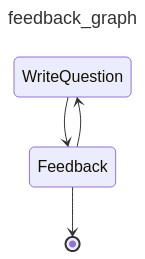

08:57:22.178 run graph feedback_graph
08:57:22.179   run node WriteQuestion
08:57:22.180     question_writer_agent run
08:57:22.180       preparing model request params
08:57:22.180       chat us.anthropic.claude-3-haiku-20240307-v1:0
08:57:24.424   run node Feedback
08:57:24.425     feedback_agent run
08:57:24.426       preparing model request params
08:57:24.426       chat anthropic.claude-3-sonnet-20240229-v1:0
Question(main_question='Can you describe a time when you had to invent a new solution to a complex problem? How did you go about simplifying the solution to make it more understandable and effective?', follow_up_questions=['How did you identify the need for a new solution?', 'What were the key steps you took to develop and refine the solution?', 'How did you ensure the solution was easy for others to understand and implement?', 'What was the outcome of implementing the new solution, and how did you assess its success?'])


In [50]:
from __future__ import annotations as _annotations

from dataclasses import dataclass, field

from pydantic import BaseModel

from pydantic_ai import Agent
from pydantic_ai.format_as_xml import format_as_xml
from pydantic_ai.messages import ModelMessage
from pydantic_graph import BaseNode, End, Graph, GraphRunContext

from pydantic_ai import Agent
from pydantic import BaseModel, Field

from IPython.display import Image, display
import asyncio

import nest_asyncio
nest_asyncio.apply()  # This allows for nested event loops in Jupyter Notebooks

@dataclass
class LeadershipPrinciple:
    name: str
    description: str

@dataclass
class Question:
    main_question: str
    follow_up_questions: list[str]

@dataclass
class State:
    leadership_principle: LeadershipPrinciple
    write_agent_messages: list[ModelMessage] = field(default_factory=list)

question_writer_agent = Agent(
    model='bedrock:us.anthropic.claude-3-haiku-20240307-v1:0',
    result_type=Question,
    system_prompt='Write an interview question for a Python software developer role.',
)


@dataclass
class WriteQuestion(BaseNode[State]):
    feedback: str | None = None

    async def run(self, ctx: GraphRunContext[State]) -> Feedback:
        if self.feedback:
            prompt = (
                f'Rewrite the question to asses the leadership principle:\n'
                f'{format_as_xml(ctx.state.leadership_principle)}\n'
                f'Feedback: {self.feedback}'
            )
        else:
            prompt = (
                f'Write the question to asses the leadership principle:\n'
                f'{format_as_xml(ctx.state.leadership_principle)}\n'
            )

        result = await question_writer_agent.run(
            prompt,
            message_history=ctx.state.write_agent_messages,
        )
        ctx.state.write_agent_messages += result.all_messages()
        return Feedback(result.data)


class QuestionRequiresRewrite(BaseModel):
    feedback: str


class QuestionOk(BaseModel):
    pass


feedback_agent = Agent[None, QuestionRequiresRewrite | QuestionOk](
    model='bedrock:anthropic.claude-3-sonnet-20240229-v1:0',
    result_type=QuestionRequiresRewrite | QuestionOk,  # type: ignore
    system_prompt=(
        'Review the interview question and check it assesses the leadership principle, if not, provide feedback.'
    ),
)


@dataclass
class Feedback(BaseNode[State, None, Question]):
    question: Question

    async def run(
        self,
        ctx: GraphRunContext[State],
    ) -> WriteQuestion | End[Question]:
        prompt = format_as_xml({'leadership_principle': ctx.state.leadership_principle, 'interview_question': self.question})
        result = await feedback_agent.run(prompt)
        if isinstance(result.data, QuestionRequiresRewrite):
            return WriteQuestion(feedback=result.data.feedback)
        else:
            return End(self.question)


async def main():
    lp = LeadershipPrinciple(
        name='Invent and Simplify',
        description='Leaders expect and require innovation and invention from their teams and always find ways to simplify. They are externally aware, look for new ideas from everywhere, and are not limited by “not invented here”. As we do new things, we accept that we may be misunderstood for long periods of time.'
    )
    state = State(lp)
    feedback_graph = Graph(nodes=(WriteQuestion, Feedback))
    
    display(Image(feedback_graph.mermaid_image()))
    
    result = await feedback_graph.run(WriteQuestion(), state=state)
    print(result.output)

asyncio.run(main())

# Workflow: Orchestrator-workers
Next, we have the orchestrator-workers workflow. A central LLM dynamically breaks down tasks and delegates these subtasks to worker LLMs.

> ![Orchestrator-workers](../public/images/pydantic-ai/orch-work.webp)
> Anthropic - Building effective agents

Let's take an example from a marketing department in a theatre. In preparation for a new show is announcement a team member needs to reachout to the casts representatives to get headshots. When they are returned, the a design team member needs to reformat them into the correct dimentions required for social media and website platforms. Finally, the socials team should be notified the assets are ready and they should work on the content for the announcement. This process is centrally orchistrated by the marketing manager, let's see if we can automate it with agents...

In [28]:
from __future__ import annotations as _annotations

from dataclasses import dataclass, field

from pydantic import BaseModel, EmailStr

from pydantic_ai import Agent
from pydantic_ai.format_as_xml import format_as_xml
from pydantic_ai.messages import ModelMessage
from pydantic_graph import BaseNode, End, Graph, GraphRunContext

from anthropic import AsyncAnthropicBedrock
from pydantic_ai.models.anthropic import AnthropicModel
from pydantic_ai import Agent
from pydantic import BaseModel, Field
from typing import Literal

from IPython.display import Image, display
import asyncio

import nest_asyncio
nest_asyncio.apply()  # This allows for nested event loops in Jupyter Notebooks

anthropic_bedrock_client = AsyncAnthropicBedrock()

@dataclass
class ActorCharacter:
    actor: str
    character: str

@dataclass
class Show:
    title: str
    actor_character_map: list[ActorCharacter]

@dataclass
class State:
    show: Show
    write_agent_messages: list[ModelMessage] = field(default_factory=list)

model = AnthropicModel(
    model_name='anthropic.claude-3-5-sonnet-20240620-v1:0',
    anthropic_client=anthropic_bedrock_client
)

@agent.tool
def send_email(ctx: RunContext[str]) -> str:
    # Use email API like resend, for now just print
    # print(ctx.deps)
    return 'Success'

def mock_receive_email():
    return """
        Hello Peter,
        Exciting to hear about the announcement, here's my headshot:

        
        Let me know if you need anything else,
        Regard,
        Michelle
    """

actor_liaison_agent = Agent(
    model,
    result_type=Question,
    system_prompt='Your name is Peter. Communicate with actors over email. Use clear and simple language, avoid waffling.',
)

@dataclass
class OrchistratorLoop(BaseNode[State]):
    feedback: str | None = None

    async def run(self, ctx: GraphRunContext[State]) -> Feedback:
        if self.feedback:
            prompt = (
                f'Orchestrate the \n'
                f'{format_as_xml(ctx.state.leadership_principle)}\n'
                f'Feedback: {self.feedback}'
            )
        else:
            prompt = (
                f'Write an interview question'
            )

        result = await question_writer_agent.run(
            prompt,
            message_history=ctx.state.write_agent_messages,
        )
        ctx.state.write_agent_messages += result.all_messages()
        return Feedback(result.data)


class QuestionRequiresWrite(BaseModel):
    feedback: str


class QuestionOk(BaseModel):
    pass


photo_editor_agent = Agent[None, QuestionRequiresWrite | QuestionOk](
    model,
    result_type=QuestionRequiresWrite | QuestionOk,  # type: ignore
    system_prompt=(
        'Review the interview question and provide feedback, question must assess the leadership principle.'
    ),
)


@dataclass
class Feedback(BaseNode[State, None, Question]):
    question: Question

    async def run(
        self,
        ctx: GraphRunContext[State],
    ) -> WriteQuestion | End[Question]:
        prompt = format_as_xml({'leadership_principle': ctx.state.leadership_principle, 'interview_question': self.question})
        result = await feedback_agent.run(prompt)
        if isinstance(result.data, QuestionRequiresWrite):
            return WriteQuestion(feedback=result.data.feedback)
        else:
            return End(self.question)


async def main():
    lp = LeadershipPrinciple(
        name='Invent and Simplify',
        description='Leaders expect and require innovation and invention from their teams and always find ways to simplify. They are externally aware, look for new ideas from everywhere, and are not limited by “not invented here”. As we do new things, we accept that we may be misunderstood for long periods of time.'
    )
    state = State(lp)
    feedback_graph = Graph(nodes=(WriteQuestion, Feedback))
    
    display(Image(feedback_graph.mermaid_image()))
    
    result = await feedback_graph.run(WriteQuestion(), state=state)
    print(result.output)

asyncio.run(main())